<a href="https://colab.research.google.com/github/Madhavi2075/OIB-SIP/blob/main/TASK_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
2# Step 1: install dependencies (one time)
!pip install -q xgboost shap


In [ ]:
# Step 2: upload dataset manually
from google.colab import files
uploaded = files.upload()  # upload the CSV file you downloaded from Kaggle


Saving car data.csv to car data (2).csv


In [ ]:
# Step 3: import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import shap
import joblib

sns.set_style("whitegrid")

# Step 4: read the uploaded file (adjust file name if needed)
df = pd.read_csv("car data (2).csv")  # change filename if different
df.head()


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [ ]:
df.info()
df.describe(include='all')
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


,0
Car_Name,0
Year,0
Selling_Price,0
Present_Price,0
Driven_kms,0
Fuel_Type,0
Selling_type,0
Transmission,0
Owner,0


In [ ]:
df['age'] = 2025 - df['Year']
df = df.drop(columns=['Year', 'Car_Name'])
df.head()


,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,11
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,12
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,8
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,14
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,11


In [ ]:
X = df.drop(columns=['Selling_Price'])
y = df['Selling_Price']

X.head()


,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,age
0,5.59,27000,Petrol,Dealer,Manual,0,11
1,9.54,43000,Diesel,Dealer,Manual,0,12
2,9.85,6900,Petrol,Dealer,Manual,0,8
3,4.15,5200,Petrol,Dealer,Manual,0,14
4,6.87,42450,Diesel,Dealer,Manual,0,11


In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_model.fit(X_train, y_train)
preds = lr_model.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("MAE:", mean_absolute_error(y_test, preds))
print("R²:", r2_score(y_test, preds))


Linear Regression RMSE: 1.8658375680942472
MAE: 1.2163740193330415
R²: 0.8488707839193138


In [ ]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("R²:", r2_score(y_test, rf_preds))


Random Forest RMSE: 0.9710616155890888
MAE: 0.6341614754098353
R²: 0.9590650430233315


In [ ]:
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42))
])

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))
print("MAE:", mean_absolute_error(y_test, xgb_preds))
print("R²:", r2_score(y_test, xgb_preds))


XGBoost RMSE: 0.9716505037510258
MAE: 0.5525498629984308
R²: 0.9590153789842826


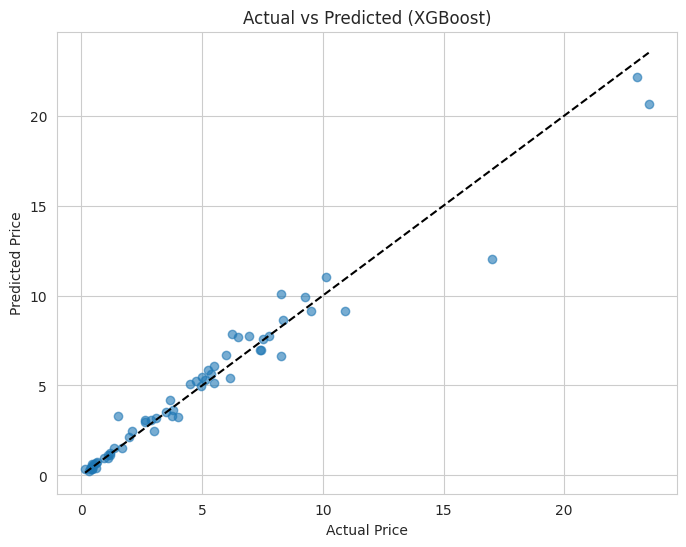

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (XGBoost)")
plt.show()


In [ ]:
joblib.dump(xgb_model, "car_price_predictor.joblib")
from google.colab import files
files.download("car_price_predictor.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>